In [1]:
import re
import csv
import codecs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences

from torch.utils.data import DataLoader, TensorDataset
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data import Field, BucketIterator, TabularDataset
from torchtext.data.utils import get_tokenizer
from torch.autograd import Variable

from gensim.models import KeyedVectors

In [2]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
df = pd.read_csv('fake_job_postings.csv', encoding='UTF-8')

df = df[(~df['company_profile'].isnull()) & (~df['description'].isnull())]
df['fraudulent'].value_counts()

0    14293
1      279
Name: fraudulent, dtype: int64

In [4]:
df.isnull().sum()

job_id                     0
title                      0
location                 284
department              9194
salary_range           12454
company_profile            0
description                0
requirements            1941
benefits                5537
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         2521
required_experience     5524
required_education      6290
industry                3714
function                4990
fraudulent                 0
dtype: int64

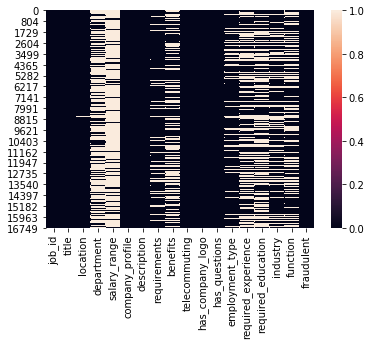

<Figure size 864x720 with 0 Axes>

In [5]:
sns.heatmap(df.isnull())
plt.figure(figsize=(12,10))
plt.show()

# Preprocessing

In [6]:
def text_to_wordlist(text):    
    """Convert words to lower case, split them, and clean punctuated words using a hard coded dictionary."""


    text = text.lower().split()
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return(text)

In [7]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word, word2index):
    return Variable(LongTensor([word2index[word]]) if word2index.get(word) is not None else LongTensor([word2index["<UNK>"]]))


In [18]:
import subprocess as sp
import os

def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    
    return memory_free_values

get_gpu_memory()

[1219]

In [13]:
comp_prof = []
job_desc = []
labels = []
test_df = df[:2000]
for row in test_df.values:
    comp_prof.append(text_to_wordlist(row[5]))
    job_desc.append(text_to_wordlist(row[6]))
    labels.append(row[-1])

print(f'Found {len(labels)} texts in fake_job_postings.csv')
print('We visualize the actual data: \n ')
print('\n', comp_prof[0])
print('\n', job_desc[0])
print('\n', labels[0])

Found 2000 texts in fake_job_postings.csv
We visualize the actual data: 
 

 we are food52 and we have created a groundbreaking and award - winning cooking site we support connect and celebrate home cooks and give them everything they need in one place we have a top editorial business and engineering team we are focused on using technology to find new and better ways to connect people around their specific food interests and to offer them superb highly curated information about food and cooking we attract the most talented home cooks and contributors in the country; we also publish well - known professionals like mario batali gwyneth paltrow and danny meyer and we have partnerships with whole foods market and random house food52 has been named the best food website by the james beard foundation and iacp and has been featured in the new york times npr pando daily techcrunch and on the today show we are located in chelsea in new york city 

 food52 a fast - growing james beard award - wi

In [15]:
# Creating the vocabulary
vocab = [entry.split() for entry in comp_prof] + [entry.split() for entry in job_desc]
flatten = lambda l: [item for sublist in l for item in sublist]
vocab.append('<UNK>')
vocab = set(flatten(vocab))

# Creating the dictionary of tokens
word2index = {'<UNK>' : 0} 

for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v:k for k, v in word2index.items()} 

In [16]:
def sequencer(text, indexer):
    '''
    A function that converts text in the data to their corresponding index values in the vocabulary 
        text    - the corpus in list form
        indexer - A dictionary of tokens as keys and their index as the value.
    '''
    new_sequence = []
    for sentence in text:
        new_sequence.append(list(map(lambda word: indexer[word] if indexer.get(word) is not None else indexer["<UNK>"], sentence)))
    return new_sequence

def padding_tensor(sequences):
    """
    :param sequences: list of tensors
    :return:
    """
    num = len(sequences)
    max_len = max([s.size(0) for s in sequences])
    out_dims = (num, max_len)
    out_tensor = sequences[0].data.new(*out_dims).fill_(0)
    mask = sequences[0].data.new(*out_dims).fill_(0)
    for i, tensor in enumerate(sequences):
        length = tensor.size(0)
        out_tensor[i, :length] = tensor
        mask[i, :length] = 1
    return torch.Tensor(out_tensor), mask

In [19]:
# indexing text
seq_comp_prof = sequencer(comp_prof, word2index)
seq_job_desc = sequencer(job_desc, word2index)

# Converting list of lists into list of tensors
for i, sent in enumerate(seq_comp_prof):
    seq_comp_prof[i] = torch.Tensor(seq_comp_prof[i])  
for i, sent in enumerate(seq_job_desc):
    seq_job_desc[i] = torch.Tensor(seq_job_desc[i])
    
# Padding sequences
data, _ = padding_tensor(seq_job_desc)

[1219]

In [21]:
# Padding sequences
data, _ = padding_tensor(seq_job_desc)

In [23]:
# split data into training, validation, testing set
split_frac = 0.8
len_feat = len(data)
train_x = data[0:int(split_frac*len_feat)]
train_y = torch.Tensor(labels[0:int(split_frac*len_feat)])
temp_remain_x = data[int(split_frac*len_feat):]
temp_remain_y = labels[int(split_frac*len_feat):]
valid_x = temp_remain_x[0:int(len(temp_remain_x)*0.5)]
valid_y = torch.Tensor(temp_remain_y[0:int(len(temp_remain_y)*0.5)])
test_x = temp_remain_x[int(len(temp_remain_x)*0.5):]
test_y = torch.Tensor(temp_remain_y[int(len(temp_remain_y)*0.5):])
print(len(train_x), len(valid_x) , len(test_x) , len(data))
assert len(train_x) + len(valid_x) + len(test_x) == len(data), 'Two lengths not equal'

# set up torch dataset
train_data = TensorDataset(train_x, train_y)
valid_data =  TensorDataset(valid_x, valid_y)  
test_data = TensorDataset(test_x, test_y)
print(train_data, valid_data, test_data)

# batching
batch_size = 10
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader =  DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

1600 200 200 2000
<torch.utils.data.dataset.TensorDataset object at 0x000001E8BAEC3EF0> <torch.utils.data.dataset.TensorDataset object at 0x000001E8BAEC30F0> <torch.utils.data.dataset.TensorDataset object at 0x000001E8BAEC3668>


# Model

In [25]:
class LSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # option (1): trained together with LSTM
        # self.embedding = embedding # option (2): pre-trained
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        
        # TODO: complete the forward propagation for LSTM
        lstm_out, hidden =  self.lstm(embeds) # NOTE: assignment section (4)
    
        # stack up lstm outputs
        # creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        # TODO: complete the drop out layer
        out = self.dropout(lstm_out) # NOTE: assignment section (5)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        # convert 2D to 1D
        sig_out = sig_out[:, -1]
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
              weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        
        return hidden



In [26]:
vocab_size = len(word2index)
output_size = 1
embedding_dim = 50
hidden_dim = 256
n_layers = 2
net = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

LSTM(
  (embedding): Embedding(21834, 50)
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [38]:
# training parameters
lr = 0.001
# TODO: specify binary cross entropy loss
criterion =  torch.nn.BCELoss() # NOTE: assignment section (6)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
epochs = 1
counter = 0
clip = 5
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

# train for some number of epochs
for e in range(epochs):
    net.train()
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        if len(inputs) != batch_size:
            print(len(inputs) , batch_size)
            continue
        counter += 1
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()
        print('gpu memory left', get_gpu_memory())
        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        # TODO: calculate the loss between predicted and labels
        
        loss = criterion(output.float(), labels.float()) 
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        

    # Get validation loss
    val_h = net.init_hidden(batch_size)
    val_losses = []
    val_acc = []
    net.eval()
    for inputs, labels in valid_loader:
        if len(inputs) != batch_size:
                
            continue

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data for each in val_h])

        inputs = inputs.type(torch.LongTensor)
        inputs, labels = inputs.cuda(), labels.cuda()
        output, val_h = net(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
        
        # accuracy
        output = (output > 0.5).float()
        output = output.type(torch.LongTensor)
        correct = (output.cpu() == labels.cpu()).float().sum()

        val_losses.append(val_loss.item())
        val_acc.append(correct / output.shape[0])

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Step: {}...".format(counter),
          #"Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)),
          "Val Accuracy: {:.6f}".format(np.mean(val_acc)))

cuda:0
gpu memory left [179]


RuntimeError: CUDA out of memory. Tried to allocate 678.00 MiB (GPU 0; 2.00 GiB total capacity; 948.77 MiB already allocated; 148.87 MiB free; 986.00 MiB reserved in total by PyTorch)

In [35]:
get_gpu_memory()

[179]

In [36]:
!nvidia-smi

Sun Jun 21 14:20:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.59       Driver Version: 442.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 950    WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8    14W / 110W |   1869MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [32]:
from collections import OrderedDict
import json
import subprocess
import sys
import time
import xml.etree.ElementTree

def extract(elem, tag, drop_s):
  text = elem.find(tag).text
  if drop_s not in text: raise Exception(text)
  text = text.replace(drop_s, "")
  try:
    return int(text)
  except ValueError:
    return float(text)

i = 0

d = OrderedDict()
d["time"] = time.time()

cmd = ['nvidia-smi', '-q', '-x']
cmd_out = subprocess.check_output(cmd)
gpu = xml.etree.ElementTree.fromstring(cmd_out).find("gpu")

util = gpu.find("utilization")
d["gpu_util"] = extract(util, "gpu_util", "%")

d["mem_used"] = extract(gpu.find("fb_memory_usage"), "used", "MiB")
d["mem_used_per"] = d["mem_used"] * 100 / 11171

if d["gpu_util"] < 15 and d["mem_used"] < 2816 :
    msg = 'GPU status: Idle \n'
else:
    msg = 'GPU status: Busy \n'

now = time.strftime("%c")
print('\n\nUpdated at %s\n\nGPU utilization: %s %%\nVRAM used: %s %%\n\n%s\n\n' % (now, d["gpu_util"],d["mem_used_per"], msg))



Updated at Sun Jun 21 14:19:53 2020

GPU utilization: 0 %
VRAM used: 16.730820875481157 %

GPU status: Idle 



